In [1]:
%matplotlib inline
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
import emcee
from numpy import exp, sqrt
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
import hast
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()

In [2]:
def abg_profile(x,p_s,r_s,al,be,ga):
    power =  (be - ga) / al
    denominator = ((x/r_s)**ga) * ((1 + (x / r_s)**al)**power)
    return p_s / denominator

In [2]:
path = "/data/MANU/anunez/output_01274"
path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
path = "/data/POL/HALOB/output_00417"
myhalo = wkbl.Galaxy_Hound(path,"halo,gas,stars",getcen=False)

loading Dark matter..
loading Stars..
loading Gas..


In [4]:
print myhalo.st.pos3d[:,1].min(), myhalo.st.pos3d[:,1].max()
print myhalo.dm.pos3d[:,1].min(), myhalo.dm.pos3d[:,1].max()
print myhalo.gs.pos3d[:,1].min(), myhalo.gs.pos3d[:,1].max()

9530.21 10339.3
0.00878533 19915.8
77.7961 19838.0


In [3]:
#ok,rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)
#centro = myhalo.st.pos3d[np.where(rho == rho.max())][0]
#print "density",centr
centro_com = nbe.real_center(myhalo.st.pos3d,myhalo.st.mass)
#myhalo.center_shift(centro)
print "done",centro_com

done [ 9685.37319441  9884.28599792  9819.20654706]


In [6]:
offset = np.sqrt((centro_com[0])**2 + (centro_com[1])**2 +(centro_com[2])**2)

print "offset = {0:.5} kpc".format(offset)

offset = 2153.2 kpc


In [6]:
#centro_com = np.array([6808.31255636, 6948.2450211, 6902.49371796])
myhalo.st.pos3d = myhalo.st.pos3d - centro_com
myhalo.dm.pos3d = myhalo.dm.pos3d - centro_com
myhalo.gs.pos3d = myhalo.gs.pos3d - centro_com

myhalo.st.r = np.sqrt((myhalo.st.pos3d[:,0]**2)+(myhalo.st.pos3d[:,1]**2)+(myhalo.st.pos3d[:,2]**2))
myhalo.dm.r = np.sqrt((myhalo.dm.pos3d[:,0]**2)+(myhalo.dm.pos3d[:,1]**2)+(myhalo.dm.pos3d[:,2]**2))
myhalo.gs.r = np.sqrt((myhalo.gs.pos3d[:,0]**2)+(myhalo.gs.pos3d[:,1]**2)+(myhalo.gs.pos3d[:,2]**2))


In [7]:
print myhalo.st.r.min(),  myhalo.st.r.max()

0.0250778127066 1492.10084461


# taking inside 300 kpc from the center

In [8]:
myhalo.dm.mass = myhalo.dm.mass[np.where(myhalo.dm.r<300.)]
myhalo.dm.pos3d = myhalo.dm.pos3d[np.where(myhalo.dm.r<300.)]
myhalo.dm.r = myhalo.dm.r[np.where(myhalo.dm.r<300)]

myhalo.st.mass = myhalo.st.mass[np.where(myhalo.st.r<300.)]
myhalo.st.pos3d = myhalo.st.pos3d[np.where(myhalo.st.r<300.)]
myhalo.st.r = myhalo.st.r[np.where(myhalo.st.r<300)]

myhalo.gs.mass = myhalo.gs.mass[np.where(myhalo.gs.r<300.)]
myhalo.gs.pos3d = myhalo.gs.pos3d[np.where(myhalo.gs.r<300.)]
myhalo.gs.r = myhalo.gs.r[np.where(myhalo.gs.r<300)]
myhalo.gs.rho = myhalo.gs.rho[np.where(myhalo.gs.r<300)]

In [9]:
myhalo.dm.vel3d = myhalo.dm.vel3d[np.where(myhalo.dm.r<300.)]

# substract mean velocities of halo

In [10]:

average = np.array([np.mean(myhalo.dm.vel3d[:,0]),
                    np.mean(myhalo.dm.vel3d[:,1]),
                    np.mean(myhalo.dm.vel3d[:,2])
                   ])
myhalo.dm.vel3d = myhalo.dm.vel3d - average

# create arrays for spherical coordinates velocities

In [11]:
myhalo.dm.R = np.sqrt((myhalo.dm.pos3d[:,0]**2)+(myhalo.dm.pos3d[:,1]**2))
myhalo.dm.vr = (myhalo.dm.vel3d[:,0]*myhalo.dm.pos3d[:,0] + \
                myhalo.dm.vel3d[:,1]*myhalo.dm.pos3d[:,1] + \
                myhalo.dm.vel3d[:,2]*myhalo.dm.pos3d[:,2])/ myhalo.dm.r

myhalo.dm.vphi = (-myhalo.dm.vel3d[:,0]*myhalo.dm.pos3d[:,1] +\
                   myhalo.dm.vel3d[:,1]*myhalo.dm.pos3d[:,0] )/ myhalo.dm.R 

In [12]:
print myhalo.st.pos3d[:,1].min(), myhalo.st.pos3d[:,1].max()
print myhalo.dm.pos3d[:,1].min(), myhalo.dm.pos3d[:,1].max()
print myhalo.gs.pos3d[:,1].min(), myhalo.gs.pos3d[:,1].max()

-223.404161985 241.99232239
-299.84361511 299.154431765
-298.346544798 299.71107239


In [13]:
print len(myhalo.dm.pos3d)
print len(myhalo.st.pos3d)
print len(myhalo.gs.pos3d)

2768040
2154125
4746960


# get densities

In [14]:
ok,rho_dm,_= CF.getDensity(np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32), myhalo.dm.mass)

In [15]:
ok,rho_st,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)

In [16]:
rho_max_st = myhalo.st.pos3d[rho_st == rho_st.max()]
rho_max_dm = myhalo.dm.pos3d[rho_dm == rho_dm.max()]

In [17]:
print rho_max_dm,rho_max_st
print rho_max_dm -rho_max_st


[[ -36.30581159  -40.54674011 -150.82373456]] [[-0.05971784 -1.06627136 -1.4086955 ]]
[[ -36.24609375  -39.48046875 -149.41503906]]


In [18]:
def beta_shell(r,r2):
    shell_condition = (myhalo.dm.r > r)&(myhalo.dm.r < r2)
    vphi_shell = myhalo.dm.vphi[shell_condition]
    vr_shell = myhalo.dm.vr[shell_condition]
    sigmaT_shell = np.std(vphi_shell)
    sigmar_shell = np.std(vr_shell)
    return 1-(sigmaT_shell/sigmar_shell)

get_beta_shell = np.vectorize(beta_shell)
    

In [19]:
r_sample = np.logspace(-1,np.log10(300),60)
r1 = r_sample[:-1]
r2 = r_sample[1:]
beta_in_shell = get_beta_shell(r1,r2)

cen = r1 +(r2-r1)/ 2


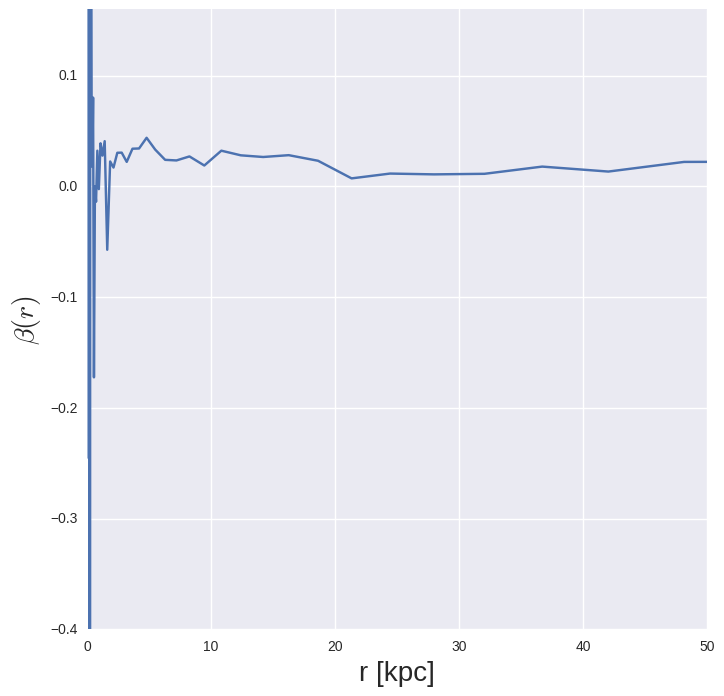

In [20]:
fig, ax = plt.subplots(figsize=[8,8])
ax.set_xlim([0,50])
ax.plot(cen,beta_in_shell)
ax.set_ylabel(r'$\beta(r)$',fontsize=20)
ax.set_xlabel(r'r [kpc]',fontsize=20)
ax.set_ylim([-0.4,0.16])
y = [i for i in np.arange(-0.2,0.18,0.01)]
x = [172 for i in y]
#ax.set_xscale('log')
ax.plot(x,y,'k--', alpha=0.5)
#ax.text(162,0.01,r'R$_{200}$',fontsize=20)
#ax.text(20,0.1,r'$\beta(r) = 1 - \frac{\sigma_T}{\sigma_r}$',fontsize=25)

In [ ]:
myhalo.dm.vel3d = myhalo.dm.vel3d + average

In [4]:
myhalo.center = centro_com

In [10]:
myhalo.r_virial(600)

starting
stackted
start histogram
 done
rotated
| r_200 = 166.9921875
| Diagonal matrix computed 
|    |20, 0, 0|
| D =| 0,14, 0|
|    | 0, 0, 2|


In [11]:
print myhalo.r200

166.9921875


In [12]:
#myhalo.center_shift(-centroide)
#pos = myhalo.dm.pos3d
#myhalo.dm.r = np.sqrt((pos[:,0]**2)+(pos[:,1]**2)+(pos[:,2]**2))
#myhalo.st.r = np.sqrt((myhalo.st.pos3d[:,0]**2)+(myhalo.st.pos3d[:,1]**2)+(myhalo.st.pos3d[:,2]**2))
#myhalo.gs.r = np.sqrt((myhalo.gs.pos3d[:,0]**2)+(myhalo.gs.pos3d[:,1]**2)+(myhalo.gs.pos3d[:,2]**2))

In [12]:
#centroide = nbe.real_ce(myhalo.dm.pos3d,myhalo.dm.mass)
#print centro_dm
#myhalo.center_shift(centro_dm)
#myhalo.redefine(2)
#print myhalo.dm.pos3d[np.where(rho_dm == rho_dm.max())]
#################################
Pcrit = myhalo.dm._p.rho_crit
Mdm = myhalo.dm.mass.min()
myradiuses = myhalo.dm.r[np.argsort(myhalo.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]
#R_hsml = myhalo.gs.hsml()
##################################
r_p = np.logspace(-1,np.log10(300),30)
dens = np.array([])
mean = np.array([])
std = np.array([])
for i in range(len(r_p)-1):
    shell = np.where((myhalo.dm.r > r_p[i])&(myhalo.dm.r < r_p[i+1]))
    mass = np.sum(myhalo.dm.mass[shell])
    mean = np.append(mean,np.mean(rho_dm[shell]))
    std = np.append(std,np.std(rho_dm[shell]))
    volume = 4.* np.pi * ((r_p[i+1]**3)-(r_p[i]**3)) / 3.
    dens = np.append(dens,mass/volume)
dens_dm = dens


NameError: name 'rho_dm' is not defined

In [16]:
mean_= (mean-std)*(((mean-std)>0))
mean_[-9]=0.0001
mean_

array([  1.56000358e+08,   1.44789500e+08,   1.49756742e+08,
         1.48540008e+08,   1.36070464e+08,   1.29536960e+08,
         1.23438392e+08,   1.18250090e+08,   1.15526450e+08,
         1.06402442e+08,   9.12578000e+07,   7.22282180e+07,
         5.19820600e+07,   3.30362500e+07,   1.89181160e+07,
         9.97266750e+06,   5.17058600e+06,   2.59415000e+06,
         1.24188375e+06,  -0.00000000e+00,   1.00000000e-04,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00])

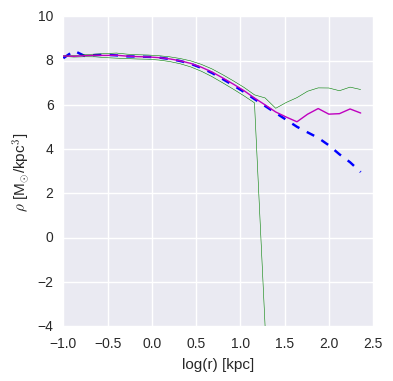

In [54]:
fig , ax = plt.subplots(figsize=[4,4])
ax.plot(np.log10(r_p[0:-1]),np.log10(dens_dm),'b--', label="data")
ax.plot(np.log10(r_p[0:-1]),np.log10(mean+std),'g-',linewidth=0.4, label="data")
ax.plot(np.log10(r_p[0:-10]),np.log10(((mean-std)*((mean-std)>0)+0.0001)[:-9]),'g-',linewidth=0.4, label="data")
ax.plot(np.log10(r_p[0:-1]),np.log10(mean),'m-',linewidth=1, label="data")

#ax.set_ylim([2,10.2])
#ax.set_xlim([-0.9,2.4])

ax.set_xlabel("log(r) [kpc]")
ax.set_ylabel(r'$\rho $ [M$_{\odot}$/kpc$^3$]')
#ax.plot(np.log10(x_P03),y,'k-.')

In [ ]:
#myhalo.center_shift(-centroide)
#pos = myhalo.st.pos3d
#myhalo.st.r = np.sqrt((pos[:,0]**2)+(pos[:,1]**2)+(pos[:,2]**2))

In [22]:
r_p = np.logspace(-1,np.log10(300),30)
dens = np.array([])
m = np.array([])
v = np.array([])
for i in range(len(r_p)-1):
    mass = np.sum(myhalo.st.mass[np.where((myhalo.st.r > r_p[i])&(myhalo.st.r < r_p[i+1]))])
    volume = 4.* np.pi * ((r_p[i+1]**3)-(r_p[i]**3)) / 3.
    dens = np.append(dens,mass/volume)
dens_st = dens

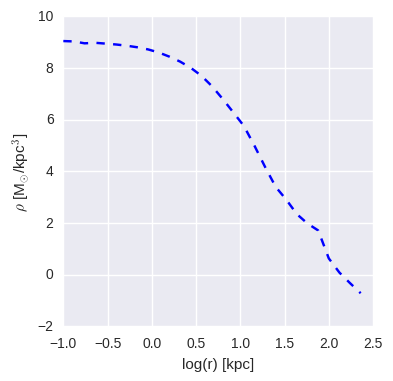

In [23]:
fig , ax = plt.subplots(figsize=[4,4])
ax.plot(np.log10(r_p[0:-1]),np.log10(dens_st),'b--', label="data")
#ax.set_ylim([2,10.2])
#ax.set_xlim([-0.9,2.4])

ax.set_xlabel("log(r) [kpc]")
ax.set_ylabel(r'$\rho $ [M$_{\odot}$/kpc$^3$]')
#ax.plot(np.log10(x_P03),y,'k-.')

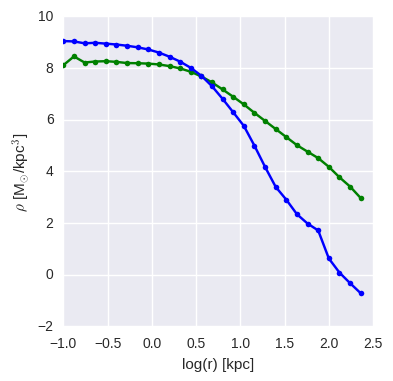

In [71]:
fig , ax = plt.subplots(figsize=[4,4])
ax.plot(np.log10(r_p[0:-1]),np.log10(dens_dm),'go-',markersize=4, label="dark matter")
ax.plot(np.log10(r_p[0:-1]),np.log10(dens_st),'bo-',markersize=4, label="stars")

#ax.set_ylim([2,10.2])
#ax.set_xlim([-1.1,2.4])

ax.set_xlabel("log(r) [kpc]")
ax.set_ylabel(r'$\rho $ [M$_{\odot}$/kpc$^3$]')
#ax.plot(np.log10(x_P03),y,'k-.')

In [70]:
mins = np.array([2e7,2,1,0,0])
maxs = np.array([2e10,6.5,4,3.8,4])
fitabg = wkbl.al_be_ga_fit(mins=mins, maxs=maxs)

params,chi2 = fitabg.bestfit(r_p[0:-1],dens_dm)
texto = "rho_0     =  {0:.3e}\nr_s       =  {1}\nalpha     =  {2}\nbeta      =  {3}\ngamma     =  {4} \nchi2        = {5}".format(params[0],params[1],params[2],params[3],params[4],chi2/1e9)

print texto


rho_0     =  1.705e+08
r_s       =  3.03048304415
alpha     =  1.95701112958
beta      =  2.85867857986
gamma     =  1.91165786624e-16 
chi2        = 0.0848045523623


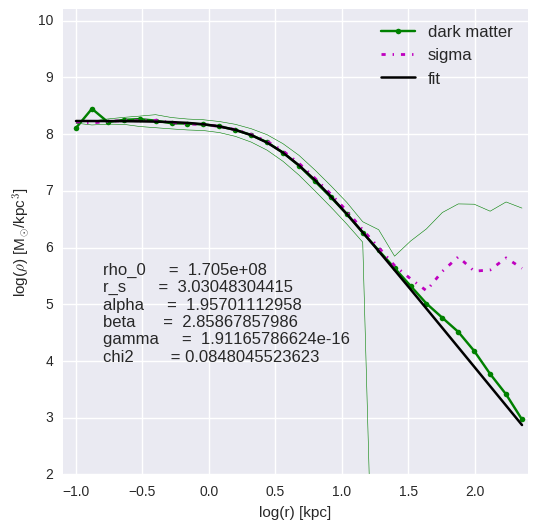

In [71]:
fig , ax = plt.subplots(figsize=[6,6])
ax.plot(np.log10(r_p[0:-1]),np.log10(dens_dm),'go-',markersize=4, label="dark matter")
#ax.plot(np.log10(r_p[0:-1]),np.log10(dens_st),'bo-',markersize=4, label="stars")


ax.plot(np.log10(r_p[0:-1]),np.log10(mean),'m-.',linewidth=2, label="sigma")
ax.plot(np.log10(r_p[0:-10]),np.log10(((mean-std)*((mean-std)>0)+0.0001)[:-9]),'g-',linewidth=0.4)
#ax.fill_between(np.log10(r_p[0:-1]),np.log10(mean+std),np.log10(mean_),facecolor='g',alpha=0.5)
ax.plot(np.log10(r_p[0:-1]),np.log10(mean+std),'g-',linewidth=0.4)
ax.plot(np.log10(r_p[0:-1]),np.log10(abg_profile(r_p[0:-1],params[0],params[1],params[2],params[3],params[4])),
        'k-',linewidth=1.8,markersize=4, label="fit")


#ax.plot(np.log10(r_p[0:-1]),np.log10(abg_profile(r_p[0:-1],10**7.663,4.425,2.895,2.541,8.19e-9
#                            )),
#        'm--',linewidth=1.8,markersize=4, label="pol's fit")

ax.set_ylim([2,10.2])
ax.set_xlim([-1.1,2.4])
y =[i for i in range(1,14)]
x_p03 =[np.log(R_P03) for i in range(1,14)]
#ax.plot(x_p03,y)
ax.set_xlabel("log(r) [kpc]")
ax.set_ylabel(r'log($\rho $) [M$_{\odot}$/kpc$^3$]')
ax.text(-0.8,4,texto)
legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=12)

In [ ]:
np.log10(1956566876)

In [ ]:
r_p[1]

In [23]:
myhalo.save_galaxy("snap1.g2","gadget2","halo")

1
1


In [ ]:
myhalo.save_galaxy("snap1st.g2","gadget2","stars")

In [1]:
myhalo.save_galaxy("snap1gs.g2","gadget2","gas")

NameError: name 'myhalo' is not defined

In [15]:
with open("Halo-C-Stars-pos-rho.txt", "w") as text_file:
    text_file.write("# Stars position and density of HALO C\n# R200 = 172 \n# format:\n#  x[kpc]     y[kpc]     z[kpc]     rho[Msun/Kpc^3] \n")
    for i in range(len(myhalo.st.r)):
        text_file.write("{0:.4e} {1:.4e} {2:.4e} {3:.4e} \n".format(myhalo.st.pos3d[i,0],
                                                           myhalo.st.pos3d[i,1],
                                                           myhalo.st.pos3d[i,2],
                                                           rho_st[i]
                                                          ))
    text_file.write("# TOTAL = {0}".format(len(myhalo.st.pos3d)))

In [16]:
with open("Halo-C-Gas-pos-rho.txt", "w") as text_file:
    text_file.write("# Gas position and density of HALO C\n# R200 = 172 \n# format:\n#  x[kpc]     y[kpc]     z[kpc]     rho[Msun/Kpc^3] \n")
    for i in range(len(myhalo.gs.r)):
        text_file.write("{0:.4e} {1:.4e} {2:.4e} {3:.4e} \n".format(myhalo.gs.pos3d[i,0],
                                                           myhalo.gs.pos3d[i,1],
                                                           myhalo.gs.pos3d[i,2],
                                                           myhalo.gs.rho[i]
                                                          ))
    text_file.write("# TOTAL = {0}".format(len(myhalo.gs.pos3d)))

In [17]:
with open("Halo-B-Anisotropy.txt", "w") as text_file:
    text_file.write("# Halo beta paramiter of HALO B\n# R200 = 172 kpc \n# format:\n#  r [kpc] beta(r) \n")
    for i in range(len(r_sample)): 
        text_file.write("{0:.4e} {1:.4e} \n".format(r_sample[i], beta_in_shell[i]))
    text_file.write("# TOTAL = {0}".format(len(r_sample)))

In [17]:
with open("Halo-C-DarkMatter-pos-rho.txt", "w") as text_file:
    text_file.write("# DM position and density of HALO C\n# R200 = 172 \n# format:\n#  x[kpc]     y[kpc]     z[kpc]     rho[Msun/Kpc^3] \n")
    for i in range(len(myhalo.dm.r)):
        text_file.write("{0:.4e} {1:.4e} {2:.4e} {3:.4e} \n".format(myhalo.dm.pos3d[i,0],
                                                           myhalo.dm.pos3d[i,1],
                                                           myhalo.dm.pos3d[i,2],
                                                           rho_dm[i]
                                                          ))
    text_file.write("# TOTAL = {0}".format(len(myhalo.dm.pos3d)))